In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import *
import numpy as np
import math
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt
from scipy.optimize import fsolve
import pylab as pl
import scipy.signal as signal

import mpld3

mpld3.enable_notebook()

('Band_1', 'Band_1RSR', 'Band_2', 'Band_2RSR', 'Band_3', 'Band_3RSR', 'Band_4', 'Band_4RSR', 'Band_5', 'Band_5RSR', 'Band_6', 'Band_6RSR', 'Band_7', 'Band_7RSR', 'Band_8', 'Band_8RSR', 'Band_9', 'Band_9RSR', 'Band_10', 'Band_10RSR', 'Band_11', 'Band_11RSR', 'Band_12', 'Band_12RSR', 'Band_13', 'Band_13RSR', 'Band_14', 'Band_14RSR', 'Band_15', 'Band_15RSR', 'Band_16', 'Band_16RSR', 'Band_17', 'Band_17RSR', 'Band_18', 'Band_18RSR', 'Band_19', 'Band_19RSR', 'Band_20', 'Band_20RSR', 'Band_21', 'Band_21RSR', 'Band_22', 'Band_22RSR', 'Band_23', 'Band_23RSR', 'Band_24', 'Band_24RSR', 'Band_25', 'Band_25RSR', 'Band_26', 'Band_26RSR', 'Band_27', 'Band_27RSR', 'Band_28', 'Band_28RSR', 'Band_29', 'Band_29RSR', 'Band_30', 'Band_30RSR', 'Band_31', 'Band_31RSR', 'Band_32', 'Band_32RSR', 'Band_33', 'Band_33RSR', 'Band_34', 'Band_34RSR', 'Band_35', 'Band_35RSR', 'Band_36', 'Band_36RSR')
[  300   301   302 ..., 14997 14998 15000] (12000,)
[ 0.000527  0.000527  0.000527 ...,  0.        0.        0.      

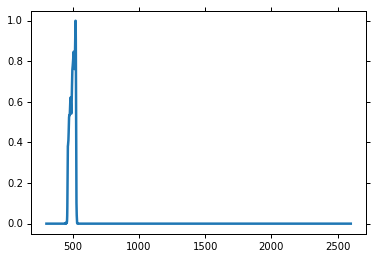

In [35]:
# Created structured array with names
s2amsi = np.genfromtxt('/home/simonaoliver/Desktop/rsr/S2AMSI.rsr', dtype=float, delimiter=',', names=True) 
ls8oli = np.genfromtxt('/home/simonaoliver/Desktop/rsr/LS8OLI.rsr', dtype=float, delimiter=',', names=True)
terra_modis = np.genfromtxt('/home/simonaoliver/Desktop/rsr/MODIS_FM1_IB_OOB_RSR_merged.csv', dtype=float, delimiter=',', names=True)
print terra_modis.dtype.names
# recast MODIS bands to same range and sampling interval as other examples (1 micron interval and 300 to 2600)
wavelength = np.linspace(300,15000,12000, dtype=int)
print wavelength, np.shape(wavelength)
#print terra_modis['Band_1']*1000
print np.nan_to_num(np.interp(wavelength,terra_modis['Band_1']*1000, terra_modis['Band_1RSR'] ))
# Assign inputs for this exercise
wavelength = s2amsi['SR_WL']
target_band = s2amsi['Band_2']
pl.plot(wavelength,target_band)
pl.show()


In [3]:
# More correctyly with gaussian fit for noise - http://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak
def gauss(x, p): # p[0]==mean, p[1]==stdev
    return 1.0/(p[1]*np.sqrt(2*np.pi))*np.exp(-(x-p[0])**2/(2*p[1]**2))

# Create some sample data
known_param = np.array([2.0, .7]) #What is this???
#xmin,xmax = wavelength.min(), wavelength.max()
#N = 1000
#X = np.linspace(xmin,xmax,N)
Y = gauss(target_band, known_param)

# Add some noise
#Y += .10*np.random.random(N)

# Renormalize to a proper PDF
#Y /= ((xmax-xmin)/N)*Y.sum()

# Fit a guassian
p0 = [0,1] # Inital guess is a normal distribution
errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
#p1, success = opt.leastsq(errfunc, p0[:], args=(X, Y))
p1, success = opt.leastsq(errfunc, p0[:], args=(target_band, Y))

fit_mu, fit_stdev = p1

FWHM = 2*np.sqrt(2*np.log(2))*fit_stdev
print "FWHM", FWHM

FWHM 0.29325383952


In [4]:
# FWHM calculation
def make_norm_dist(x, mean, sd):
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

#target_band.max()
# create a spline of wavelength and blue-np.max(blue)/2 
spline = UnivariateSpline(wavelength, target_band-target_band.max()/2, s=0)

# find the roots
r1, r2 = spline.roots()

In [5]:
# FWHM calculation
fwhm = 2*np.sqrt(2*(math.log(2)))*target_band.std()

print "FWHM",fwhm
#fwhm_np = np.zeros_like(wavelength, float)  
#fwhm_np[fwhm_np == 0.0]=fwhm

FWHM 0.267053394554


In [6]:
def findIntersection(fun1,fun2,x0):
 return fsolve(lambda x : fun1(x) - fun2(x),x0)

/home/simonaoliver/venvs/agdc-v2/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/simonaoliver/venvs/agdc-v2/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


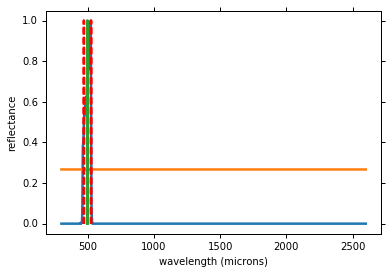

In [7]:
shapex = np.shape(wavelength)
shapey = np.shape(target_band)

# Power weighted mean wavelength
mean_wavelength = np.average(wavelength, weights=target_band)

# axhline, axvline don't play nicely with mpld3 - make arrays instead
fwhm_array = np.full(shapex,fwhm, dtype=np.float)
mean_wavelength_array = np.full(shapey, mean_wavelength, dtype=np.float)
r1_array = np.full(shapey, r1, dtype=np.float)
r2_array = np.full(shapey, r2, dtype=np.float)

#print np.shape(mean_wavelength_array)
#print np.shape(fwhm_array)

pl.plot(wavelength,target_band)
pl.plot(wavelength, fwhm_array)
pl.plot(mean_wavelength_array, target_band)
pl.plot(r1_array, target_band, 'r--')
pl.plot(r2_array, target_band, 'r--')

#pl.axvspan(r1, r2, facecolor='grey', alpha=0.5)
pl.xlabel('wavelength (microns)')
pl.ylabel('reflectance')
wavelength.min()
#pl.xlim(r1,r2)

#pl.axhline(fwhm)
#pl.axvline(mean_wavelength)
pl.show()

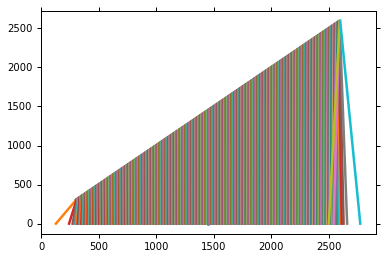

-0.4909003674983978

In [15]:
#from pyemd import emd
#from pyemd import emd
#import numpy as np
#X = np.array([wavelength,ls8oli['blue']])
#print np.shape(X)
#print X
#Y = np.array([wavelength,ls8oli['green']])
#print np.shape(Y)
#distance_matrix = scipy.spatial.distance.cdist(X,Y, 'euclidean')
#print np.shape(distance_matrix)
#print distance_matrix
#emd(X,Y,distance_matrix)

# From - https://github.com/andreasjansson/python-emd
import emd
X = signal.resample(ls8oli['blue'], 920, wavelength)
Y = signal.resample(wavelength, 920,wavelength )
pl.plot(Y, X)
pl.show()
#emd.emd(range(10), range(10), signal.resample(ls8oli['blue'],230), signal.resample(ls8oli['green'],230))
#looks like need to make these gaussian distributions otherwise - blurgh
emd.emd(range(500), range(500), signal.resample(ls8oli['blue'],500), signal.resample(ls8oli['blue'],500))

In [9]:
# numpy cross correlate 
print np.correlate(ls8oli['blue'],s2amsi['Band_2'])
print np.average(wavelength, weights=ls8oli['blue']) - np.average(wavelength, weights=s2amsi['Band_2'])
print np.correlate(ls8oli['green'],s2amsi['Band_3'])
print np.average(wavelength, weights=ls8oli['green']) - np.average(wavelength, weights=s2amsi['Band_3'])
print np.correlate(ls8oli['red'],s2amsi['Band_4'])

#np.correlate(ls8oli['nir'],s2amsi['Band_5'])
#np.correlate(ls8oli['swir1'],s2amsi['Band_6'])

[ 30.92087001]
-13.95220979
[ 30.41111774]
1.32576669687
[ 21.81463255]


In [10]:
def plotcomparison(x,y,colour):
    spline = UnivariateSpline(x, y-y.max()/2, s=0)
    # find the roots
    r1, r2 = spline.roots()
    fwhm = 2*np.sqrt(2*(math.log(2)))*y.std()
    shapex = np.shape(x)
    shapey = np.shape(y)

    # Power weighted mean wavelength
    mean_wavelength = np.average(x, weights=y)
    fwhm_array = np.full(shapex,fwhm, dtype=np.float)
    mean_wavelength_array = np.full(shapey, mean_wavelength, dtype=np.float)
    r1_array = np.full(shapey, r1, dtype=np.float)
    r2_array = np.full(shapey, r2, dtype=np.float)

    pl.plot(x,y)
    pl.plot(x, fwhm_array)
    pl.plot(mean_wavelength_array, y, colour)
    pl.plot(r1_array, y, 'r--')
    pl.plot(r2_array, y, 'r--')

    pl.xlabel('wavelength (microns)')
    pl.ylabel('reflectance')

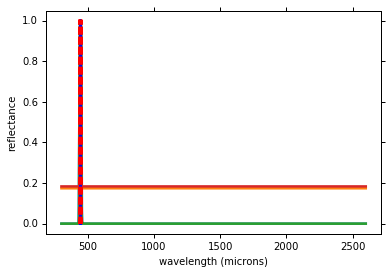

correlate: [ 12.73287304] trapz: Band_1

ValueError: no field of name Band_1

In [16]:
for i in s2amsi.dtype.names:
    for j in ls8oli.dtype.names:
        if (i == 'SR_WL') or (j == 'SR_WL'):
            print
        else:
            
            plotcomparison(wavelength,s2amsi[i],'g')
            plotcomparison(wavelength,ls8oli[j],'b')
            pl.show()
            print "correlate:", np.correlate(s2amsi[i],ls8oli[j]), "trapz:", i, np.trapz(ls8oli[i], wavelength), j, np.trapz(s2amsi[j], wavelength) 


In [ ]:
pl.plot(wavelength,ls8oli['blue'],wavelength,s2amsi['Band_2'])
pl.show()

In [ ]:
print np.trapz(ls8oli['blue'],wavelength)
print np.average(wavelength, weights=ls8oli['blue'])
print np.trapz(s2amsi['Band_2'],wavelength)
print np.average(wavelength, weights=s2amsi['Band_2'])
print np.trapz(ls8oli['green'], wavelength)
print np.average(wavelength, weights=ls8oli['green'])
print np.trapz(s2amsi['Band_3'],wavelength)
print np.average(wavelength, weights=s2amsi['Band_3'])